# National mRS distributions

This notebook creates a plot of the mRS distributions averaged across England and Wales.

## Plain English summary

This notebook loads the data that we created in a previous notebook. It loads the mRS distributions averaged across all parts of England and Wales where redirection from the nearest stroke unit to an MT centre makes a difference to which stroke unit is attended first.

## Aims

Plot the national mRS distributions for these cohorts:
+ nLVO with IVT
+ LVO with mixed treatments
+ treated ischaemic population


## Methods

Load in the existing data.

Create new no-treatment mRS distributions for the weighted combination by combining the separate nLVO and LVO no-treatment distributions in the required proportions.

Plot the mRS distributions and the cumulative probabilities.

In [1]:
dir_output = 'output'
limit_to_england = False

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_outcome.outcome_utilities

pd.set_option('display.max_rows', 150)

In [3]:
stroke_outcome.__version__

'0.1.6'

## Load data

Results from outcome model:

In [4]:
df_mrs_national_cumsum = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national.csv'), index_col=0)

In [5]:
df_mrs_national_cumsum

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
drip_ship_lvo_ivt,0.10356,0.19544,0.32788,0.49012,0.70857,0.82316,1.0
drip_ship_lvo_ivt_mt,0.11472,0.22605,0.37176,0.54453,0.75047,0.85084,1.0
drip_ship_lvo_mix,0.11382,0.22365,0.36835,0.54031,0.74723,0.84869,1.0
drip_ship_lvo_mt,0.11449,0.22589,0.37170,0.54455,0.75052,0.85086,1.0
drip_ship_nlvo_ivt,0.36134,0.58906,0.70508,0.82416,0.92123,0.95515,1.0
drip_ship_weighted,0.18250,0.39015,0.51547,0.65399,0.81988,0.89575,1.0
drip_ship_weighted_treated,0.23655,0.40482,0.53531,0.68105,0.83350,0.90148,1.0
mothership_lvo_ivt,0.09705,0.18809,0.32101,0.48329,0.70384,0.81982,1.0
mothership_lvo_ivt_mt,0.15523,0.27670,0.42080,0.59378,0.78327,0.87247,1.0
mothership_lvo_mix,0.15072,0.26984,0.41306,0.58522,0.77711,0.86839,1.0


In [6]:
df_mrs_national_noncum = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national_noncum.csv'), index_col=0)

In [7]:
df_mrs_national_noncum

,mRS=0,mRS=1,mRS=2,mRS=3,mRS=4,mRS=5,mRS=6
drip_ship_lvo_ivt,0.10356,0.09188,0.13244,0.16224,0.21845,0.11459,0.17684
drip_ship_lvo_ivt_mt,0.11472,0.11133,0.14571,0.17277,0.20594,0.10037,0.14916
drip_ship_lvo_mix,0.11382,0.10983,0.14470,0.17197,0.20692,0.10146,0.15131
drip_ship_lvo_mt,0.11449,0.11139,0.14582,0.17284,0.20597,0.10034,0.14914
drip_ship_nlvo_ivt,0.36134,0.22771,0.11603,0.11907,0.09707,0.03393,0.04485
drip_ship_weighted,0.18250,0.20765,0.12532,0.13852,0.16589,0.07586,0.10425
drip_ship_weighted_treated,0.23655,0.16828,0.13048,0.14574,0.15245,0.06798,0.09852
mothership_lvo_ivt,0.09705,0.09104,0.13293,0.16228,0.22054,0.11599,0.18018
mothership_lvo_ivt_mt,0.15523,0.12147,0.14409,0.17298,0.18949,0.08921,0.12753
mothership_lvo_mix,0.15072,0.11911,0.14323,0.17215,0.19189,0.09128,0.13161


In [8]:
df_mrs_national_std = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national_std.csv'), index_col=0)

In [9]:
df_mrs_national_std

,mRS=0,mRS=1,mRS=2,mRS=3,mRS=4,mRS=5,mRS=6
drip_ship_lvo_ivt,0.00262,0.00029,0.00022,0.00003,0.00083,0.00055,0.00129
drip_ship_lvo_ivt_mt,0.00983,0.00399,0.00143,0.00129,0.00452,0.00355,0.00729
drip_ship_lvo_mix,0.00784,0.00317,0.00112,0.00102,0.00360,0.00283,0.00580
drip_ship_lvo_mt,0.01037,0.00373,0.00054,0.00080,0.00460,0.00347,0.00723
drip_ship_nlvo_ivt,0.00667,0.00215,0.00039,0.00064,0.00160,0.00074,0.00116
drip_ship_weighted,0.00128,0.00048,0.00015,0.00015,0.00049,0.00037,0.00074
drip_ship_weighted_treated,0.00515,0.00192,0.00060,0.00060,0.00198,0.00147,0.00298
mothership_lvo_ivt,0.00568,0.00090,0.00035,0.00004,0.00188,0.00128,0.00309
mothership_lvo_ivt_mt,0.01227,0.00250,0.00093,0.00032,0.00475,0.00307,0.00577
mothership_lvo_mix,0.00978,0.00199,0.00074,0.00025,0.00378,0.00245,0.00460


In [10]:
cols_each_scen = df_mrs_national_noncum.index.values

cols_each_scen

array(['drip_ship_lvo_ivt', 'drip_ship_lvo_ivt_mt', 'drip_ship_lvo_mix',
       'drip_ship_lvo_mt', 'drip_ship_nlvo_ivt', 'drip_ship_weighted',
       'drip_ship_weighted_treated', 'mothership_lvo_ivt',
       'mothership_lvo_ivt_mt', 'mothership_lvo_mix', 'mothership_lvo_mt',
       'mothership_nlvo_ivt', 'mothership_weighted',
       'mothership_weighted_treated'], dtype=object)

Reference no-treatment mRS distributions:

In [11]:
mrs_dists, mrs_dists_notes = (
    stroke_outcome.outcome_utilities.import_mrs_dists_from_file())

In [12]:
mrs_dists

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
Stroke type,,,,,,,
pre_stroke_nlvo,0.583,0.746,0.850,0.951,0.993,1.000,1
pre_stroke_lvo,0.408,0.552,0.672,0.838,0.956,1.000,1
no_treatment_lvo,0.050,0.129,0.265,0.429,0.676,0.811,1
no_treatment_nlvo,0.198,0.460,0.580,0.708,0.856,0.918,1
no_effect_nlvo_ivt_deaths,0.196,0.455,0.574,0.701,0.847,0.908,1
no_effect_lvo_ivt_deaths,0.048,0.124,0.255,0.414,0.653,0.783,1
no_effect_lvo_mt_deaths,0.048,0.124,0.255,0.412,0.649,0.779,1
t0_treatment_nlvo_ivt,0.445,0.642,0.752,0.862,0.941,0.967,1
t0_treatment_lvo_ivt,0.140,0.233,0.361,0.522,0.730,0.838,1


In [13]:
mrs_dist_nlvo_no_treatment = mrs_dists.loc['no_treatment_nlvo'].values
mrs_dist_lvo_no_treatment = mrs_dists.loc['no_treatment_lvo'].values

mrs_dist_nlvo_no_treatment_noncum = np.diff(mrs_dist_nlvo_no_treatment, prepend=0.0)
mrs_dist_lvo_no_treatment_noncum = np.diff(mrs_dist_lvo_no_treatment, prepend=0.0)

Stroke type proportions:

In [14]:
proportions = pd.read_csv(
    os.path.join(dir_output, 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [15]:
proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

### Calculate weighted no treatment dist:

In [16]:
prop_lvo_treated = 0.0
prop_nlvo_treated = 0.0

for key, value in proportions.items():
    if ('nlvo' in key) & ('no_treatment' not in key):
        prop_nlvo_treated += value
    elif ('lvo' in key) & ('no_treatment' not in key):
        prop_lvo_treated += value

In [17]:
prop_lvo_treated, prop_nlvo_treated

(0.10840000000000001, 0.1066)

In [18]:
prop_lvo_treated / (prop_nlvo_treated + prop_lvo_treated), prop_nlvo_treated / (prop_nlvo_treated + prop_lvo_treated)

(0.5041860465116279, 0.49581395348837204)

In [19]:
mrs_dist_weighted_no_treatment_noncum = (
    (mrs_dist_nlvo_no_treatment_noncum * prop_nlvo_treated) +
    (mrs_dist_lvo_no_treatment_noncum * prop_lvo_treated)
)

# Remove the non-treated patients:
mrs_dist_weighted_no_treatment_noncum = (
    mrs_dist_weighted_no_treatment_noncum / (prop_nlvo_treated + prop_lvo_treated)
)

In [20]:
np.sum(mrs_dist_weighted_no_treatment_noncum)

1.0

In [21]:
# Same structure as the other distribution dictionaries:
dict_no_treat = {
    'nlvo': {
        'values': mrs_dist_nlvo_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_nlvo_no_treatment_noncum)
    },
    'lvo': {
        'values': mrs_dist_lvo_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_lvo_no_treatment_noncum)
    },
    # 'weighted': {
    #     'values': mrs_dist_weighted_no_treatment_noncum,
    #     'cumsum': np.cumsum(mrs_dist_weighted_no_treatment_noncum)
    # },
    'weighted_treated': {
        'values': mrs_dist_weighted_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_weighted_no_treatment_noncum)
    },
}

## Gather data for plots

In [22]:
def gather_dists(scenario, df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum):
    d = {}

    for cohort in ['nlvo_ivt', 'lvo_mix', 'weighted_treated']:
        ind = f'{scenario}_{cohort}'

        d[cohort] = {}
        d[cohort]['values'] = df_mrs_national_noncum.loc[ind]
        d[cohort]['std'] = df_mrs_national_std.loc[ind]
        d[cohort]['cumsum'] = df_mrs_national_cumsum.loc[ind]
    
    return d

In [23]:
dict_drip_ship = gather_dists('drip_ship', df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum)
dict_mothership = gather_dists('mothership', df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum)

## Plot

In [24]:
colour_drip = '#00517f'   # seaborn colorblind blue darker
colour_moth = '#0072b2'  # seaborn colorblind blue
colour_no_treat = 'DarkGray'

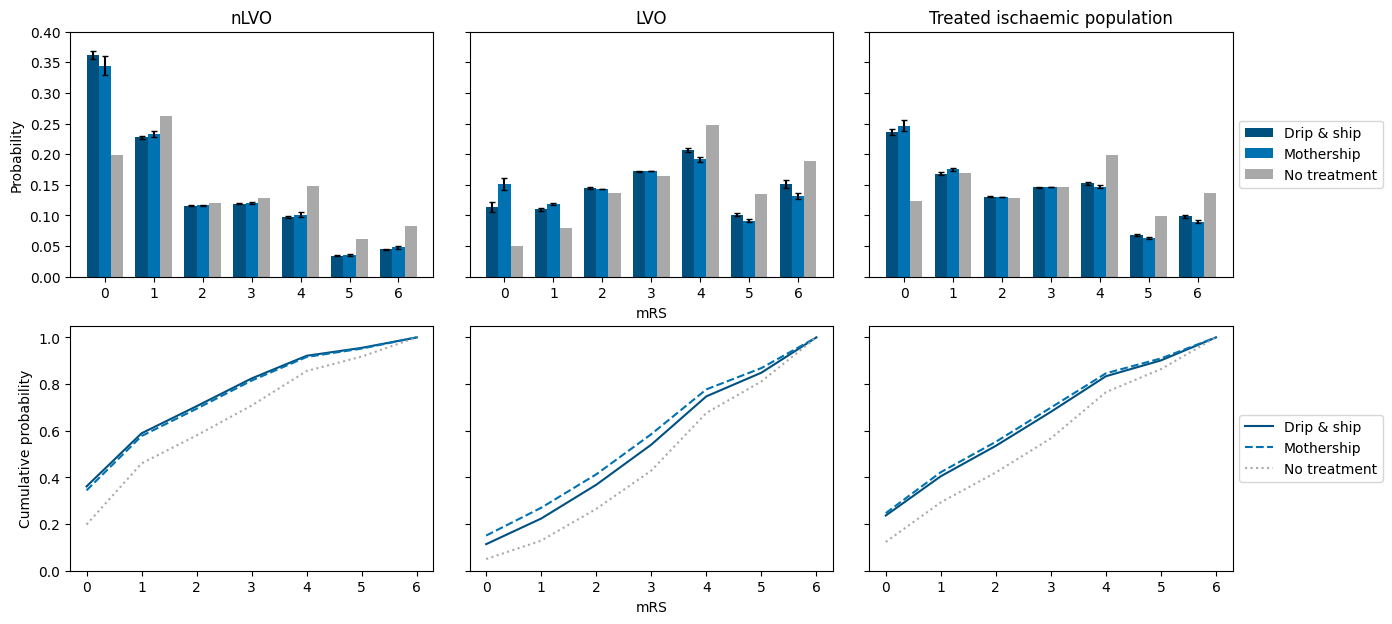

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'wspace': 0.1})

bar_width = 0.25
offsets = [-bar_width, 0.0, bar_width]

legend_drawn = False
for c, cohort in enumerate(['nlvo_ivt', 'lvo_mix', 'weighted_treated']):
    dist_drip = dict_drip_ship[cohort]['values']
    std_drip = dict_drip_ship[cohort]['std']
    dist_cumsum_drip = dict_drip_ship[cohort]['cumsum']
    dist_moth = dict_mothership[cohort]['values']
    std_moth = dict_mothership[cohort]['std']
    dist_cumsum_moth = dict_mothership[cohort]['cumsum']
    
    if 'nlvo' in cohort:
        ax = axs[0, 0]
        ax_cumsum = axs[1, 0]
        dist_no_treat = dict_no_treat['nlvo']['values']
        dist_cumsum_no_treat = dict_no_treat['nlvo']['cumsum']
    elif 'lvo' in cohort:
        ax = axs[0, 1]
        ax_cumsum = axs[1, 1]
        dist_no_treat = dict_no_treat['lvo']['values']
        dist_cumsum_no_treat = dict_no_treat['lvo']['cumsum']
    elif 'treated' in cohort:
        ax = axs[0, 2]
        ax_cumsum = axs[1, 2]
        dist_no_treat = dict_no_treat['weighted_treated']['values']
        dist_cumsum_no_treat = dict_no_treat['weighted_treated']['cumsum']
    # else:
    #     ax = axs[0, -1]
    #     ax_cumsum = axs[1, -1]
    #     dist_no_treat = dict_no_treat['weighted']['values']
    #     dist_cumsum_no_treat = dict_no_treat['weighted']['cumsum']

    ax.bar(
        np.arange(7) + offsets[0], dist_drip, yerr=std_drip, capsize=2.0,
        facecolor=colour_drip, label='Drip & ship', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[1], dist_moth, yerr=std_moth, capsize=2.0,
        facecolor=colour_moth, label='Mothership', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[2], dist_no_treat,
        facecolor=colour_no_treat, label='No treatment', width=bar_width
        )

    ax_cumsum.plot(np.arange(7), dist_cumsum_drip, color=colour_drip, linestyle='-', label='Drip & ship')
    ax_cumsum.plot(np.arange(7), dist_cumsum_moth, color=colour_moth, linestyle='--', label='Mothership')
    ax_cumsum.plot(np.arange(7), dist_cumsum_no_treat, color=colour_no_treat, linestyle=':', label='No treatment')

    if c == 2:
        ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
        ax_cumsum.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
        legend_drawn = True

for i, ax_list in enumerate(axs):
    ylim = [0, 0.4] if i == 0 else [0.0, 1.05]
    for j, ax in enumerate(ax_list):
        ax.set_ylim(*ylim)
        ax.set_xticks(range(7))
        if (j > 0):  # & (j < len(ax_list) - 1):
            ax.set_yticklabels([])

axs[0, 0].set_title('nLVO')
axs[0, 1].set_title('LVO')
axs[0, 2].set_title('Treated ischaemic population')
# axs[0, -1].set_title('Total\nischaemic population')

axs[0, 0].set_ylabel('Probability')
# axs[0, -1].set_ylabel('Probability')
# axs[0, -1].yaxis.set_tick_params(labelleft=True)  # turn the tick labels back on
axs[0, 1].set_xlabel('mRS')
# axs[0, -1].set_xlabel('mRS')

axs[1, 0].set_ylabel('Cumulative probability')
# axs[1, -1].set_ylabel('Cumulative probability')
# axs[1, -1].yaxis.set_tick_params(labelleft=True)  # turn the tick labels back on
axs[1, 1].set_xlabel('mRS')
# axs[1, -1].set_xlabel('mRS')

# axs[0, 3].axis('off')
# axs[1, 3].axis('off')

plt.savefig(os.path.join(dir_output, 'mrs_dists_redirection_areas.png'), bbox_inches='tight')
plt.show()

## Find mean values

Import utility scores

In [26]:
utility_dists, utility_dists_notes = (
    stroke_outcome.outcome_utilities.import_utility_dists_from_file())

utility_weights = utility_dists.loc['Wang2020'].values

In [27]:
dist_dicts = {
    'drip_ship': dict_drip_ship,
    'mothership': dict_mothership,
    'no_treat': dict_no_treat
}

In [28]:
df_means = pd.DataFrame()

for scenario, dist_dict in dist_dicts.items():
    for cohort, d_dict in dist_dict.items():
            
        if 'nlvo' in cohort:
            dist_no_treat = dict_no_treat['nlvo']['values']
        elif 'lvo' in cohort:
            dist_no_treat = dict_no_treat['lvo']['values']
        elif 'treated' in cohort:
            dist_no_treat = dict_no_treat['weighted_treated']['values']
        else:
            print('help')
            # dist_no_treat = dict_no_treat['weighted']['values']

        mean_mrs_no_treat = np.mean(dist_no_treat * np.arange(7))
        mean_util_no_treat = np.mean(dist_no_treat * utility_weights)
        mrsleq2_no_treat = np.sum(dist_no_treat[:3])
            
        dist = d_dict['values']
        ind = f'{scenario}_{cohort}'
        df_means.loc[ind, 'mean_mrs'] = np.mean(dist * np.arange(7))
        df_means.loc[ind, 'mean_util'] = np.mean(dist * utility_weights)
        df_means.loc[ind, 'mrsleq2'] = np.sum(dist[:3])
        df_means.loc[ind, 'mean_mrs_shift'] = (
            df_means.loc[ind, 'mean_mrs'] - mean_mrs_no_treat)
        df_means.loc[ind, 'mean_util_shift'] = (
            df_means.loc[ind, 'mean_util'] - mean_util_no_treat)
        df_means.loc[ind, 'mrsleq2_shift'] = (
            df_means.loc[ind, 'mrsleq2'] - mrsleq2_no_treat)

In [29]:
df_means

,mean_mrs,mean_util,mrsleq2,mean_mrs_shift,mean_util_shift,mrsleq2_shift
drip_ship_nlvo_ivt,0.234859,0.102172,0.705080,-0.090856,0.016509,0.125080
drip_ship_lvo_mix,0.451140,0.061546,0.368350,-0.068860,0.014031,0.103350
drip_ship_weighted_treated,0.343897,0.081689,0.535310,-0.079773,0.015260,0.114129
mothership_nlvo_ivt,0.242964,0.100770,0.694310,-0.082750,0.015107,0.114310
mothership_lvo_mix,0.419377,0.067532,0.413060,-0.100623,0.020016,0.148060
mothership_weighted_treated,0.331910,0.084012,0.552510,-0.091760,0.017582,0.131329
no_treat_nlvo,0.325714,0.085663,0.580000,0.000000,0.000000,0.000000
no_treat_lvo,0.520000,0.047516,0.265000,0.000000,0.000000,0.000000
no_treat_weighted_treated,0.423670,0.066430,0.421181,0.000000,0.000000,0.000000


### Save a copy of data behind the figure

Keep a copy of the separate LVO cohorts even though the figure only shows the combined LVO cohort.

Add the no-treatment distributions into the starting data:

In [30]:
for key, value in dict_no_treat.items():
    ind = f'no_treatment_{key}'
    df_mrs_national_noncum.loc[ind] = value
    df_mrs_national_std.loc[ind] = pd.NA

In [31]:
# Save to file:
df_mrs_national_noncum.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists.csv'))
df_mrs_national_std.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists_std.csv'))

In [32]:
df_means.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists_means.csv'))

## Conclusions

For nLVO, the mRS distributions are weighted slightly lower (less disability) for the drip-and-ship scenario. For LVO, they are weighted lower (less disability) for the mothership scenario. For the combined cohort, the mothership scenario just wins out. This is most easily seen by looking at which scenario is highest on the cumulative probability plots.